# Sobol indices

In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Gaussian Framework

In [2]:
from shapley.tests import AdditiveGaussian
dim = 2
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
theta = [0.3]
model.copula_parameters = theta

if True:
    dim = 3
    beta = None
    model = AdditiveGaussian(dim=dim, beta=beta)
    model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
    theta = [0., 0., 0.5]
    model.copula_parameters = theta

### Monte-Carlo estimation using true model

In [3]:
%%time
from shapley import ShapleyIndices
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_perms = None
n_var = 1000
n_outer = 80
n_inner = 10

budget_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * budget_perms * (dim - 1)
print('Max budget:', max_budget)

shapley = ShapleyIndices(model.input_distribution)
shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner)

Max budget: 10600
Wall time: 1.31 s


In [4]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_boot = 300
shapley_results = shapley.compute_indices(n_boot=n_boot)

Wall time: 103 ms


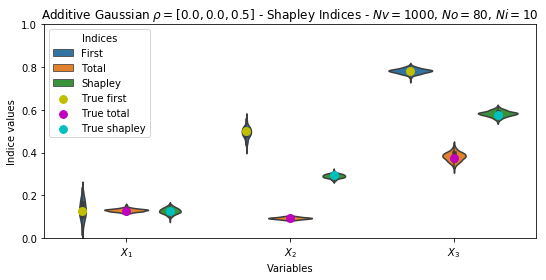

In [9]:
from shapley.plots import plot_sensitivity_results
ylim = [0., 1.]

fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Shapley Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(
    theta, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

In [14]:
X = np.asarray(model.get_input_sample(2000, 'monte-carlo'))
y = model(X)

In [15]:
%%time
from sklearn.ensemble import RandomForestRegressor
from shapley.forest import compute_perm_indices, compute_shap_indices
n_tree = 100
rfq = RandomForestRegressor(n_estimators=n_tree, n_jobs=7)
rfq.fit(X, y)

Wall time: 288 ms


In [16]:
%%time
sobol_permutation = {}
for i, indice_type in enumerate(['full', 'ind']):
    sobol_permutation[indice_type] = compute_perm_indices(rfq, X, y, model.input_distribution, indice_type=indice_type)
    sobol_permutation[indice_type].true_first_indices = model.first_sobol_indices
    sobol_permutation[indice_type].true_total_indices = model.total_sobol_indices

Wall time: 3.78 s


In [17]:
%%time
shapley_permutation = compute_shap_indices(rfq, X, y, model.input_distribution)

Wall time: 5.28 s


In [20]:
from shapley.indices import SensitivityResults
results_permutation = SensitivityResults()
results_permutation.first_indices = sobol_permutation['full']._first_indices
results_permutation.total_indices = sobol_permutation['ind']._total_indices
results_permutation.shapley_indices = shapley_permutation._shapley_indices
results_permutation.true_first_indices = model.first_sobol_indices
results_permutation.true_total_indices = model.total_sobol_indices
results_permutation.true_shapley_indices = model.shapley_indices

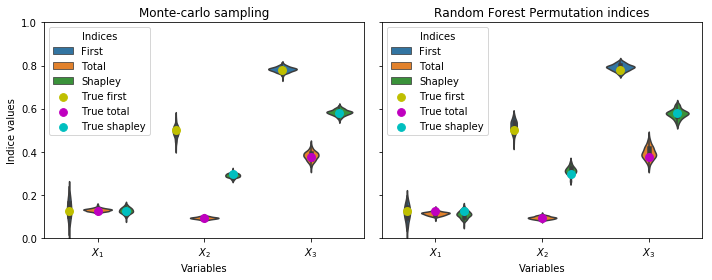

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
indice_type = 'full'
ax = axes[0]
plot_sensitivity_results(shapley_results, ax=ax)
ax.set_title('Monte-carlo sampling')
ax = axes[1]
plot_sensitivity_results(results_permutation, ax=ax)
ax.set_ylabel('')
ax.set_title('Random Forest Permutation indices')
ax.set_ylim(ylim)
fig.tight_layout()
fig.savefig('output/gaussian_montecarlo_vs_randomforest.pdf')

### Monte-Carlo estimation using a Kriging model

In [10]:
from shapley.kriging import KrigingModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_budget = 15
sampling = 'lhs'
library = 'gpflow'
kernel = 'matern'
basis = 'linear'

model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
model_gp.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
model_gp.build(library=library, kernel=kernel, basis_type=basis)

In [11]:
# The score of the meta_model
q2_score_cv_gp = model_gp.compute_score_q2_cv(n_sample=10000, sampling='monte-carlo')
print('Q2-score by cross-validation:', q2_score_cv_gp)

Q2-score by cross-validation: 1.0


In [12]:
%%time
n_realization = 200
shapley.build_sample(model=model_gp, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)

Wall time: 1min 37s


In [13]:
%%time
# Indice estimation
shapley_gp_results = shapley.compute_indices(n_boot=n_boot)

Wall time: 16.7 s


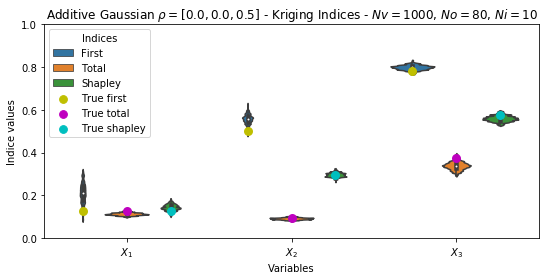

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_gp_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(
    theta, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

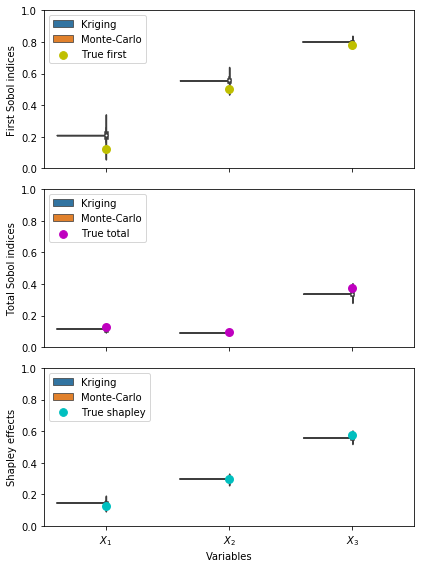

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_gp_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(shapley_gp_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(shapley_gp_results, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()

### Monte-Carlo estimation using a Random Forest model

In [ ]:
from shapley.forest import RandomForestModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_rf = RandomForestModel(model=model, input_distribution=model.input_distribution)
model_rf.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
model_rf.build(n_realization, method='random-forest')

In [ ]:
# The score of the meta_model
q2_score_cv_rf = model_rf.compute_score_q2_cv(n_sample=10000, sampling='monte-carlo')
print('Q2-score by cross-validation:', q2_score_cv_rf)

In [ ]:
%%time
shapley.build_sample(model=model_rf, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)

In [ ]:
%%time
shapley_rf_results = shapley.compute_indices(n_boot=n_boot)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_rf_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(
    theta, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_rf_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(shapley_rf_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(shapley_rf_results, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()